In [1]:
%matplotlib inline
import sys
sys.path.append('/home/paulo/github')

import time
import datetime

import numpy as np
import pandas as pd

from bayeseg.SeqSeg import SeqSeg

savefolder = '/home/paulo/github/bayeseg/Output/'

## Computing time for various time resolutions

Note: the cell below replicates the results reported on Table 1, p. 11 of the paper. However, the replication is not exact, since the computing times depend on uncontrollable factors (such as system's architecture)

In [5]:
# This comparison cannot be made to be exact with the results in the paper, since it depends 
# on the system's characteristics and on other software that might be possibly running simultaneously

ss = SeqSeg()


sizes = [10000, 100000, 1000000]
tres = [1, 10, 100, 1000]

ss.initialize(1, 0.1, 100, 200, 1)
result = []
np.random.seed(123456)
for size in sizes:
    signal = np.random.normal(0, 1, [size, 1])
    ss.feed_data(signal)
    for res in tres:
        t, tdur = ss.segments(minlen = 1000000, res = res, verbose = False)
        print("Size = " + str(size) + ", tres = " + str(res) + ", t = ", str(tdur))
        result.append([size, res, tdur])

Size = 10000, tres = 1, t =  0.006590366363525391
Size = 10000, tres = 10, t =  0.0030541419982910156
Size = 10000, tres = 100, t =  0.008252143859863281
Size = 10000, tres = 1000, t =  0.008683443069458008
Size = 100000, tres = 1, t =  0.03670048713684082
Size = 100000, tres = 10, t =  0.004834175109863281
Size = 100000, tres = 100, t =  0.0030434131622314453
Size = 100000, tres = 1000, t =  0.0008645057678222656
Size = 1000000, tres = 1, t =  0.2952098846435547
Size = 1000000, tres = 10, t =  0.03573131561279297
Size = 1000000, tres = 100, t =  0.008868694305419922
Size = 1000000, tres = 1000, t =  0.005087137222290039


In [5]:
import pandas as pd
df = pd.DataFrame(final, columns = ['nsignal', 'stdnoise', 'delta', 'mciter', 'minev', 'maxev', 'accavg', 'dhat', 'shat', 'dRhat', 'sRhat'])

# Generate latex code
print(df.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &  nsignal &  stdnoise &  delta &  mciter &    minev &    maxev &    accavg &      dhat &      shat &     dRhat &     sRhat \\
\midrule
0 &   500000 &         1 &    1.0 &    1000 &  0.96100 &  1.00000 &  0.023250 &  1.000344 &  1.000005 &  2.236312 &  2.130287 \\
1 &   500000 &         1 &    1.0 &   10000 &  0.97260 &  0.98510 &  0.100125 &  1.000527 &  1.000023 &  1.009749 &  1.004708 \\
2 &   500000 &         1 &    1.0 &  100000 &  0.97617 &  0.98112 &  0.136043 &  1.000595 &  0.999983 &  1.000193 &  1.000106 \\
3 &   500000 &         1 &    1.1 &    1000 &  0.00000 &  0.00000 &  0.018500 &  1.098619 &  0.999929 &  1.328783 &  1.111929 \\
4 &   500000 &         1 &    1.1 &   10000 &  0.00000 &  0.00000 &  0.052250 &  1.097646 &  1.000127 &  1.010574 &  1.011942 \\
5 &   500000 &         1 &    1.1 &  100000 &  0.00000 &  0.00000 &  0.107863 &  1.097803 &  1.000070 &  1.000113 &  1.000146 \\
6 &   500000 &         1 &    1.5 &    1000 &  0

# Testing convergence of MCMC method for evidence value calculation

Note: the cells below replicate the results reported on Table 2, p. 13 of the paper

In [2]:

def cposterior_full(d, s, Nw, N2, beta, sum1, sum2):
    ''' Full log-posterior kernel for MCMC sampling

        Arguments:

        d - current value for delta
        s - current value for sigma
        Nw - total signal size
        N2 - size of second segment
        beta - parameter for laplace prior
        sum1 - sum of amplitudes squared for first segment
        sum2 - sum of amplitudes squared for second segment
    '''
    
    if d <= 0 or s <= 0:
        return -1e+308
    
    # Jeffreys' prior for sigma
    dpriors = -np.log(s)

    # Laplace prior for delta
    dpriord = -np.log(beta) - abs(d-1)/beta

    post = dpriord +  dpriors - Nw*np.log(s)-0.5*N2*np.log(d)
    post = post - sum1/(2*(s**2)) - sum2/(2*d*(s**2))

    return post


In [3]:
def mcmc(p0, mcburn, mciter, beta, N, N2, sum1, sum2):
    ''' Run MCMC

        Arguments:

        mcburn - burn-in period for chain
        mciter - number of points to sample
        p0 - posterior under H0
        beta - parameter for Laplace prior
        N - total signal size
        N2 - size of second segment
        sum1 - sum of amplitude squared for the first segment
        sum2 - sum of amplitude squared for the second segment

    '''
    
    dcur = (sum2 / (N2-1))/(sum1 / (N-N2-1))
    scur = np.sqrt(sum1 / (N-N2-1))

    # Standard deviations and covariance for random-walk candidates distributions
    dvar = (dcur / 3) ** 2
    svar = (scur / 3) ** 2
    cov = 0.0
    
    dcur = abs(dcur + np.random.normal(0, dvar))
    scur = abs(scur + np.random.normal(0, svar))

    pcur = cposterior_full(dcur, scur, N, N2, beta, sum1, sum2)
    
    
    # Parameters for adaptive MH
    sd = (2.4*2.4)/2.0
    eps = 1e-30

    # Starting point for adaptive MH
    t0 = 500
    
    dmean = 0.0
    smean = 0.0
    sumdsq = 0.0
    sumssq = 0.0
    cov0 = 0.0
    accept = 0
    for i in range(t0):
        
        # Generate candidates
        u1 = np.random.normal(0, 1)
        dcand = dcur + u1*np.sqrt(dvar)
        
        if dcand > 0:
            # Calculates full posterior
            pcand = cposterior_full(dcand, scur, N, N2, beta, sum1, sum2)

            # Acceptance ratio
            #a = Exp(pcand - pcur) * Exp(scand - scur)
            a = (pcand - pcur)

            if np.log(np.random.uniform()) < a:
                dcur = dcand
                pcur = pcand
                accept = accept + 1
            #endif        
        
        u2 = np.random.normal(0, 1)
        scand = abs(scur + np.sqrt(svar)*u2)
        
        if scand > 0:
            # Calculates full posterior
            pcand = cposterior_full(dcur, scand, N, N2, beta, sum1, sum2)

            # Acceptance ratio
            #a = Exp(pcand - pcur) * Exp(scand - scur)
            a = (pcand - pcur)

            if np.log(np.random.uniform()) < a:
                scur = scand
                pcur = pcand
                accept = accept + 1
            #endif
        
        dmean = dmean + dcur 
        smean = smean + scur
        cov0 = cov0 + dcur*scur 
        sumdsq = sumdsq + dcur*dcur 
        sumssq = sumssq + scur*scur 
        
    #endfor
    
    assert accept > 0
    tmp = dmean*dmean/t0
    tmp = sumdsq - tmp
    dvar = tmp/(t0-1.0)
    tmp = smean*smean/t0
    tmp = sumssq - tmp
    svar = tmp/(t0-1.0)
    
    if svar < 0:
        print(accept)
        print((smean*smean)/t0)
        print([sumssq, smean, t0])
        print(svar)
    
    cov = (1/(t0-1))*(cov0 - dmean*smean/t0)
    rho = cov/(np.sqrt(dvar*svar))
    dmean = dmean / t0
    smean = smean / t0    
    t = t0

    accept = 0
    for i in range(mcburn):
        
        # Generate candidates
        u1 = np.random.normal(0, 1)
        u2 = np.random.normal(0, 1)
        if abs(rho) > 1:
            print([dvar, svar, cov])
            assert abs(rho) <= 1
        u2 = rho * u1 + (1 - rho) * u2
        
        dcand = dcur + u1*np.sqrt(dvar)
        #scand = scur + (cov/np.sqrt(dvar))*u1 + np.sqrt(svar - (cov*cov)/(dvar))*u2
        scand = scur + u2*np.sqrt(svar)
        
        if dcand > 0 and scand > 0:
            # Calculates full posterior
            pcand = cposterior_full(dcand, scand, N, N2, beta, sum1, sum2)

            # Acceptance ratio
            #a = Exp(pcand - pcur) * Exp(scand - scur)
            a = (pcand - pcur)

            if np.log(np.random.uniform()) < a:
                scur = scand
                dcur = dcand
                pcur = pcand
                accept = accept + 1
            #endif
            
        # Updating covariance matrix
        dmeanant = dmean
        smeanant = smean
        dmean = (t*dmeanant + dcur) / (t + 1)
        smean = (t*smeanant + scur) / (t + 1)            
        dvar =  ((t-1.0)*dvar)/t + (sd/t)*(t*dmeanant*dmeanant - (t+1)*dmean*dmean + dcur*dcur + eps)
        
        if ((t-1.0)*svar)/t + (sd/t)*(t*smeanant*smeanant - (t+1)*smean*smean + scur*scur + eps) < 0:
            print([t, svar, sd, smeanant, smean, scur, eps])        
        
        svar =  ((t-1.0)*svar)/t + (sd/t)*(t*smeanant*smeanant - (t+1)*smean*smean + scur*scur + eps)
        cov = ((t-1.0)*cov)/t + (sd/t)*(t*dmeanant*smeanant - (t+1)*dmean*smean + dcur*scur)

        rho = cov/(np.sqrt(dvar*svar))
        t = t + 1
        assert dvar > 0
        assert svar > 0
            
    #endfor

    accept = 0
    ev = 0
    sample = []
    for i in range(mciter):
        # Generate candidates
        u1 = np.random.normal(0, 1)
        u2 = np.random.normal(0, 1)
        u2 = rho*u1 + (1-rho)*u2
        
        dcand = dcur + u1*np.sqrt(dvar)
        #scand = scur + (cov/np.sqrt(dvar))*u1 + np.sqrt(svar - (cov*cov)/(dvar))*u2
        scand = scur + np.sqrt(svar)*u2

        if dcand > 0 and scand > 0:
            # Calculates full posterior
            pcand = cposterior_full(dcand, scand, N, N2, beta, sum1, sum2)

            # Acceptance ratio
            a = pcand - pcur

            if np.log(np.random.uniform()) < a:
                dcur = dcand
                scur = scand
                pcur = pcand
                accept = accept + 1
            #endif
        sample.append([dcur, scur])
        if pcur > p0:
            ev = ev + 1
    
    ev = 1 - ev / mciter

    return sample, ev, accept / mciter


In [4]:
# Simulates signal: one change point
n1 = 500000
n2 = 500000
N = n1 + n2
stdnoise = [1]
delta = [1, 1.1, 1.5]

mciter = [1000, 10000, 100000]
beta = 1

M = 4
final = []
cont = 0
total = len(stdnoise) * len(delta) * len(mciter) 

# Set random seed for replication purposes
np.random.seed(123456)
for sn in stdnoise:
    for d in delta:
        signal = np.concatenate([np.random.normal(0, sn, [n1, 1]), np.random.normal(0, np.sqrt(d)*sn, [n2, 1])])
        sum1 = sum(signal[:n1]**2)
        sum2 = sum(signal[n1:]**2)
        s0 = np.sqrt((sum1 + sum2)/(N + 1.))
        p0 = cposterior_full(1.0, s0, N, n2, beta, sum1, sum2)
        for mn in mciter:
            measures = []
            for i in range(M):
                sample, ev, acc = mcmc(p0, mn, mn, beta, n1+n2, n2, sum1, sum2)
                dsample = np.asarray([s[0] for s in sample])
                ssample = np.asarray([s[1] for s in sample])
                davg = dsample.mean()
                savg = ssample.mean()
                dvar = dsample.var()*(mn/(mn-1))
                svar = ssample.var()*(mn/(mn-1))
                measures.append([davg, savg, dvar, svar, ev, acc])
                
            minev = min([m[4] for m in measures])
            maxev = max([m[4] for m in measures])
            dhat = (1/M)*sum([m[0] for m in measures])
            shat = (1/M)*sum([m[1] for m in measures])
            dB = (1 / (M-1))*sum([(m[0] - dhat)**2 for m in measures])
            sB = (1 / (M-1))*sum([(m[1] - shat)**2 for m in measures])
            dW = (1/M)*sum([m[2] for m in measures])
            sW = (1/M)*sum([m[3] for m in measures])
            accavg = (1/M)*sum([m[5] for m in measures])
            dVhat = (mn-1)/mn * dW + dB + dB / M
            sVhat = (mn-1)/mn * sW + sB + sB / M
            dRhat = dVhat / dW
            sRhat = sVhat / sW
            final.append([n1, sn, d, mn, minev, maxev, accavg, dhat, shat, dRhat, sRhat])
            print("Run " + str(cont+1) + " of " + str(total))
            cont = cont + 1


Run 1 of 9
Run 2 of 9
Run 3 of 9
Run 4 of 9
Run 5 of 9
Run 6 of 9
Run 7 of 9
Run 8 of 9
Run 9 of 9


## Testing $\alpha = 0.1$, several values of $\beta$

Note: the cell below replicates the results reported on Table 3, p. 13 of the paper

In [12]:
npoints = 1000000
cuts = [10000, 110000, 200000, 500000, 750000, 1000000]
deltalist = [1, 1.1, 1.5]
stdnoise = 1

mciter = 20000
mcburn = 10000
alphalist = [0.1]
betalist = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

nruns = 30

# replicate = True to replicate results
ss = SeqSeg(replicate = True)
res = []

np.random.seed(123456)

for delta in deltalist:
    # Simulates signal
    signal = np.random.normal(0, 1, [npoints, 1])
    for i in range(len(cuts)):
        if (i+1)%2:
            signal[cuts[i]:cuts[i+1]] = signal[cuts[i]:cuts[i+1]]*(np.sqrt(delta))
    ss.feed_data(signal)
    for beta in betalist:
        for alpha in alphalist:
            ss.initialize(beta, alpha, mciter, mcburn, nchains = 1)
            nsegmean = 0
            minseg = 500000
            maxseg = 0
            tmean = 0
            for i in range(nruns):
                t, tdur = ss.segments(minlen = 5000, res = 100, verbose = False)
                nsegmean = nsegmean + (len(t)+1)/nruns
                tmean = tmean + tdur / nruns
                if len(t) + 1 < minseg:
                    minseg = len(t) + 1
                if len(t) + 1 > maxseg:
                    maxseg = len(t) + 1
            
            print("Delta = " + str(delta) + ", alpha = " + str(alpha) + ", beta = " + str(beta) + ", " + str(minseg) + " minimum segments, " + str(maxseg) + " maximum segments on " + "{:.2}".format(tmean) + " seconds.")
                
            res.append([delta, beta, alpha, nsegmean, minseg, maxseg, tdur])
            

df = pd.DataFrame(res, columns = ['delta', 'beta', 'alpha', 'nsegmean', 'minseg', 'maxseg', 'tmean'])
print(df[['delta', 'beta', 'minseg', 'maxseg', 'tmean']].to_latex(index = False))

Delta = 1, alpha = 0.1, beta = 1, 1 minimum segments, 1 maximum segments on 0.0083 seconds.
Delta = 1, alpha = 0.1, beta = 0.1, 1 minimum segments, 1 maximum segments on 0.0089 seconds.
Delta = 1, alpha = 0.1, beta = 0.01, 1 minimum segments, 1 maximum segments on 0.009 seconds.
Delta = 1, alpha = 0.1, beta = 0.001, 1 minimum segments, 1 maximum segments on 0.0092 seconds.
Delta = 1, alpha = 0.1, beta = 0.0001, 1 minimum segments, 1 maximum segments on 0.009 seconds.
Delta = 1, alpha = 0.1, beta = 1e-05, 1 minimum segments, 1 maximum segments on 0.009 seconds.
Delta = 1.1, alpha = 0.1, beta = 1, 6 minimum segments, 6 maximum segments on 0.1 seconds.
Delta = 1.1, alpha = 0.1, beta = 0.1, 6 minimum segments, 6 maximum segments on 0.11 seconds.
Delta = 1.1, alpha = 0.1, beta = 0.01, 6 minimum segments, 6 maximum segments on 0.1 seconds.
Delta = 1.1, alpha = 0.1, beta = 0.001, 5 minimum segments, 5 maximum segments on 0.12 seconds.
Delta = 1.1, alpha = 0.1, beta = 0.0001, 1 minimum segment

## Testing $\alpha = 0.5$, several values of $\beta$

Note: the cell below replicates the results reported on Table 4, p. 14 of the paper

In [13]:
npoints = 1000000
cuts = [10000, 110000, 200000, 500000, 750000, 1000000]
deltalist = [1, 1.1, 1.5]
stdnoise = 1

mciter = 20000
mcburn = 10000
alphalist = [0.5]
betalist = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

nruns = 30

# replicate = True to replicate results
ss = SeqSeg(replicate = True)
res = []

np.random.seed(123456)

for delta in deltalist:
    # Simulates signal
    signal = np.random.normal(0, 1, [npoints, 1])
    for i in range(len(cuts)):
        if (i+1)%2:
            signal[cuts[i]:cuts[i+1]] = signal[cuts[i]:cuts[i+1]]*(np.sqrt(delta))
    ss.feed_data(signal)
    for beta in betalist:
        for alpha in alphalist:
            ss.initialize(beta, alpha, mciter, mcburn, nchains = 1)
            nsegmean = 0
            minseg = 500000
            maxseg = 0
            tmean = 0
            for i in range(nruns):
                t, tdur = ss.segments(minlen = 5000, res = 100, verbose = False)
                nsegmean = nsegmean + (len(t)+1)/nruns
                tmean = tmean + tdur / nruns
                if len(t) + 1 < minseg:
                    minseg = len(t) + 1
                if len(t) + 1 > maxseg:
                    maxseg = len(t) + 1
            
            print("Delta = " + str(delta) + ", alpha = " + str(alpha) + ", beta = " + str(beta) + ", " + str(minseg) + " minimum segments, " + str(maxseg) + " maximum segments on " + "{:.2}".format(tmean) + " seconds.")
                
            res.append([delta, beta, alpha, nsegmean, minseg, maxseg, tdur])
            

df = pd.DataFrame(res, columns = ['delta', 'beta', 'alpha', 'nsegmean', 'minseg', 'maxseg', 'tmean'])
print(df[['delta', 'beta', 'minseg', 'maxseg', 'tmean']].to_latex(index = False))

Delta = 1, alpha = 0.5, beta = 1, 1 minimum segments, 1 maximum segments on 0.0085 seconds.
Delta = 1, alpha = 0.5, beta = 0.1, 1 minimum segments, 1 maximum segments on 0.0091 seconds.
Delta = 1, alpha = 0.5, beta = 0.01, 1 minimum segments, 1 maximum segments on 0.0093 seconds.
Delta = 1, alpha = 0.5, beta = 0.001, 1 minimum segments, 1 maximum segments on 0.0093 seconds.
Delta = 1, alpha = 0.5, beta = 0.0001, 1 minimum segments, 1 maximum segments on 0.0092 seconds.
Delta = 1, alpha = 0.5, beta = 1e-05, 1 minimum segments, 1 maximum segments on 0.0091 seconds.
Delta = 1.1, alpha = 0.5, beta = 1, 6 minimum segments, 7 maximum segments on 0.1 seconds.
Delta = 1.1, alpha = 0.5, beta = 0.1, 6 minimum segments, 7 maximum segments on 0.11 seconds.
Delta = 1.1, alpha = 0.5, beta = 0.01, 6 minimum segments, 6 maximum segments on 0.1 seconds.
Delta = 1.1, alpha = 0.5, beta = 0.001, 5 minimum segments, 5 maximum segments on 0.11 seconds.
Delta = 1.1, alpha = 0.5, beta = 0.0001, 1 minimum segm

## Testing $\alpha = 0.9$, several values of $\beta$

Note: the cell below replicates the results reported on Table 4, p. 14 of the paper

In [14]:
npoints = 1000000
cuts = [10000, 110000, 200000, 500000, 750000, 1000000]
deltalist = [1, 1.1, 1.5]
stdnoise = 1

mciter = 20000
mcburn = 10000
alphalist = [0.9]
betalist = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

nruns = 30

# replicate = True to replicate results
ss = SeqSeg(replicate = True)
res = []

np.random.seed(123456)

for delta in deltalist:
    # Simulates signal
    signal = np.random.normal(0, 1, [npoints, 1])
    for i in range(len(cuts)):
        if (i+1)%2:
            signal[cuts[i]:cuts[i+1]] = signal[cuts[i]:cuts[i+1]]*(np.sqrt(delta))
    ss.feed_data(signal)
    for beta in betalist:
        for alpha in alphalist:
            ss.initialize(beta, alpha, mciter, mcburn, nchains = 1)
            nsegmean = 0
            minseg = 500000
            maxseg = 0
            tmean = 0
            for i in range(nruns):
                t, tdur = ss.segments(minlen = 5000, res = 100, verbose = False)
                nsegmean = nsegmean + (len(t)+1)/nruns
                tmean = tmean + tdur / nruns
                if len(t) + 1 < minseg:
                    minseg = len(t) + 1
                if len(t) + 1 > maxseg:
                    maxseg = len(t) + 1
            
            print("Delta = " + str(delta) + ", alpha = " + str(alpha) + ", beta = " + str(beta) + ", " + str(minseg) + " minimum segments, " + str(maxseg) + " maximum segments on " + "{:.2}".format(tmean) + " seconds.")
                
            res.append([delta, beta, alpha, nsegmean, minseg, maxseg, tdur])
            

df = pd.DataFrame(res, columns = ['delta', 'beta', 'alpha', 'nsegmean', 'minseg', 'maxseg', 'tmean'])
print(df[['delta', 'beta', 'minseg', 'maxseg', 'tmean']].to_latex(index = False))

Delta = 1, alpha = 0.9, beta = 1, 1 minimum segments, 1 maximum segments on 0.0084 seconds.
Delta = 1, alpha = 0.9, beta = 0.1, 1 minimum segments, 1 maximum segments on 0.009 seconds.
Delta = 1, alpha = 0.9, beta = 0.01, 1 minimum segments, 1 maximum segments on 0.012 seconds.
Delta = 1, alpha = 0.9, beta = 0.001, 1 minimum segments, 1 maximum segments on 0.012 seconds.
Delta = 1, alpha = 0.9, beta = 0.0001, 1 minimum segments, 1 maximum segments on 0.009 seconds.
Delta = 1, alpha = 0.9, beta = 1e-05, 1 minimum segments, 1 maximum segments on 0.0091 seconds.
Delta = 1.1, alpha = 0.9, beta = 1, 7 minimum segments, 8 maximum segments on 0.1 seconds.
Delta = 1.1, alpha = 0.9, beta = 0.1, 7 minimum segments, 8 maximum segments on 0.11 seconds.
Delta = 1.1, alpha = 0.9, beta = 0.01, 6 minimum segments, 6 maximum segments on 0.1 seconds.
Delta = 1.1, alpha = 0.9, beta = 0.001, 5 minimum segments, 5 maximum segments on 0.1 seconds.
Delta = 1.1, alpha = 0.9, beta = 0.0001, 1 minimum segments,

## Testing $\alpha = 0.99$, several values of $\beta$

Note: the cell below replicates the results reported on Table 4, p. 14 of the paper

In [15]:
npoints = 1000000
cuts = [10000, 110000, 200000, 500000, 750000, 1000000]
deltalist = [1, 1.1, 1.5]
stdnoise = 1

mciter = 20000
mcburn = 10000
alphalist = [0.99]
betalist = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

nruns = 30

# replicate = True to replicate results
ss = SeqSeg(replicate = True)
res = []

np.random.seed(123456)

for delta in deltalist:
    # Simulates signal
    signal = np.random.normal(0, 1, [npoints, 1])
    for i in range(len(cuts)):
        if (i+1)%2:
            signal[cuts[i]:cuts[i+1]] = signal[cuts[i]:cuts[i+1]]*(np.sqrt(delta))
    ss.feed_data(signal)
    for beta in betalist:
        for alpha in alphalist:
            ss.initialize(beta, alpha, mciter, mcburn, nchains = 1)
            nsegmean = 0
            minseg = 500000
            maxseg = 0
            tmean = 0
            for i in range(nruns):
                t, tdur = ss.segments(minlen = 5000, res = 100, verbose = False)
                nsegmean = nsegmean + (len(t)+1)/nruns
                tmean = tmean + tdur / nruns
                if len(t) + 1 < minseg:
                    minseg = len(t) + 1
                if len(t) + 1 > maxseg:
                    maxseg = len(t) + 1
            
            print("Delta = " + str(delta) + ", alpha = " + str(alpha) + ", beta = " + str(beta) + ", " + str(minseg) + " minimum segments, " + str(maxseg) + " maximum segments on " + "{:.2}".format(tmean) + " seconds.")
                
            res.append([delta, beta, alpha, nsegmean, minseg, maxseg, tdur])
            

df = pd.DataFrame(res, columns = ['delta', 'beta', 'alpha', 'nsegmean', 'minseg', 'maxseg', 'tmean'])
print(df[['delta', 'beta', 'minseg', 'maxseg', 'tmean']].to_latex(index = False))

Delta = 1, alpha = 0.99, beta = 1, 1 minimum segments, 1 maximum segments on 0.0085 seconds.
Delta = 1, alpha = 0.99, beta = 0.1, 1 minimum segments, 1 maximum segments on 0.0093 seconds.
Delta = 1, alpha = 0.99, beta = 0.01, 1 minimum segments, 1 maximum segments on 0.009 seconds.
Delta = 1, alpha = 0.99, beta = 0.001, 1 minimum segments, 1 maximum segments on 0.0094 seconds.
Delta = 1, alpha = 0.99, beta = 0.0001, 1 minimum segments, 1 maximum segments on 0.01 seconds.
Delta = 1, alpha = 0.99, beta = 1e-05, 1 minimum segments, 1 maximum segments on 0.0092 seconds.
Delta = 1.1, alpha = 0.99, beta = 1, 7 minimum segments, 8 maximum segments on 0.11 seconds.
Delta = 1.1, alpha = 0.99, beta = 0.1, 7 minimum segments, 8 maximum segments on 0.12 seconds.
Delta = 1.1, alpha = 0.99, beta = 0.01, 6 minimum segments, 6 maximum segments on 0.11 seconds.
Delta = 1.1, alpha = 0.99, beta = 0.001, 5 minimum segments, 5 maximum segments on 0.1 seconds.
Delta = 1.1, alpha = 0.99, beta = 0.0001, 1 min

## Calibration for a grid of $\beta$ and $\alpha$ with varying delta

Note: the cells below replicate the results of figures 2 and 3, p. 17 of the paper

In [23]:
# Signal characteristics
npoints = 1000000
cuts = [10000, 110000, 200000, 500000, 750000, 1000000]
delta = [1.1, 1, 1.5, 1, 1.2]
stdnoise = 1

mciter = 10000
mcburn = 10000

# Alpha grid
alphamin = 0.1
alphamax = 0.1
nstep = 0
adelta = (alphamax - alphamin) / max(1, nstep)
alphalist = [alphamin + d*adelta for d in range(nstep+1)]

# Beta grid
betamin = 1e-5
betamax = 1e-3
nstep = 100
bdelta = (betamax - betamin) / max(1, nstep)
betalist = [betamin + d*bdelta for d in range(nstep+1)]

# To use union of two separate grids 
betamin = 1e-3
betamax = 1e-1
nstep = 100
bdelta = (betamax - betamin) / max(1, nstep)
betalist = betalist + [betamin + d*bdelta for d in range(nstep+1)]

# Number of segmentations to run for each combination of parameters
nruns = 1

ss = SeqSeg(replicate = True)
res = []

# To replicate results 
np.random.seed(123456)

# Simulates signal
signal = np.random.normal(0, stdnoise, [npoints, 1])
for i in range(len(cuts)-1):
    signal[cuts[i]:cuts[i+1]] = signal[cuts[i]:cuts[i+1]]*(np.sqrt(delta[i]))


ss.feed_data(signal)        
result = []
tresult = []
cont = 1
ntotal = len(betalist)*len(alphalist)
for alpha in alphalist:
    for beta in betalist:
        ss.initialize(beta, alpha, mciter, mcburn, nchains = 1)
        t, tdur = ss.segments(minlen = 5000, res = 1, verbose = False)
        result.append([alpha, beta, len(t)+1])
        #t.sort()
        tresult.append(t)

        print('({:.2%})'.format(cont/ntotal) + ' Alpha = {:.3}'.format(alpha) + ', Beta = {:.5}'.format(beta) + ", " + str(len(t)+1) + " segments")
        cont = cont + 1         




(0.50%) Alpha = 0.1, Beta = 1e-05, 1 segments
(0.99%) Alpha = 0.1, Beta = 1.99e-05, 1 segments
(1.49%) Alpha = 0.1, Beta = 2.98e-05, 1 segments
(1.98%) Alpha = 0.1, Beta = 3.97e-05, 1 segments
(2.48%) Alpha = 0.1, Beta = 4.96e-05, 2 segments
(2.97%) Alpha = 0.1, Beta = 5.95e-05, 3 segments
(3.47%) Alpha = 0.1, Beta = 6.94e-05, 3 segments
(3.96%) Alpha = 0.1, Beta = 7.93e-05, 3 segments
(4.46%) Alpha = 0.1, Beta = 8.92e-05, 3 segments
(4.95%) Alpha = 0.1, Beta = 9.91e-05, 4 segments
(5.45%) Alpha = 0.1, Beta = 0.000109, 4 segments
(5.94%) Alpha = 0.1, Beta = 0.0001189, 4 segments
(6.44%) Alpha = 0.1, Beta = 0.0001288, 4 segments
(6.93%) Alpha = 0.1, Beta = 0.0001387, 4 segments
(7.43%) Alpha = 0.1, Beta = 0.0001486, 4 segments
(7.92%) Alpha = 0.1, Beta = 0.0001585, 4 segments
(8.42%) Alpha = 0.1, Beta = 0.0001684, 4 segments
(8.91%) Alpha = 0.1, Beta = 0.0001783, 4 segments
(9.41%) Alpha = 0.1, Beta = 0.0001882, 4 segments
(9.90%) Alpha = 0.1, Beta = 0.0001981, 4 segments
(10.40%) Alpha

(81.68%) Alpha = 0.1, Beta = 0.06337, 6 segments
(82.18%) Alpha = 0.1, Beta = 0.06436, 6 segments
(82.67%) Alpha = 0.1, Beta = 0.06535, 6 segments
(83.17%) Alpha = 0.1, Beta = 0.06634, 6 segments
(83.66%) Alpha = 0.1, Beta = 0.06733, 6 segments
(84.16%) Alpha = 0.1, Beta = 0.06832, 6 segments
(84.65%) Alpha = 0.1, Beta = 0.06931, 6 segments
(85.15%) Alpha = 0.1, Beta = 0.0703, 6 segments
(85.64%) Alpha = 0.1, Beta = 0.07129, 6 segments
(86.14%) Alpha = 0.1, Beta = 0.07228, 6 segments
(86.63%) Alpha = 0.1, Beta = 0.07327, 6 segments
(87.13%) Alpha = 0.1, Beta = 0.07426, 6 segments
(87.62%) Alpha = 0.1, Beta = 0.07525, 6 segments
(88.12%) Alpha = 0.1, Beta = 0.07624, 6 segments
(88.61%) Alpha = 0.1, Beta = 0.07723, 6 segments
(89.11%) Alpha = 0.1, Beta = 0.07822, 6 segments
(89.60%) Alpha = 0.1, Beta = 0.07921, 6 segments
(90.10%) Alpha = 0.1, Beta = 0.0802, 6 segments
(90.59%) Alpha = 0.1, Beta = 0.08119, 6 segments
(91.09%) Alpha = 0.1, Beta = 0.08218, 6 segments
(91.58%) Alpha = 0.1, 

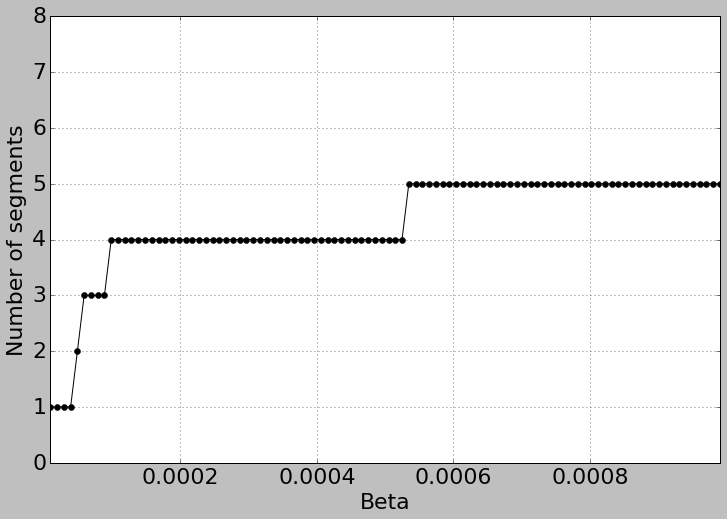

In [24]:
# Create plot for figure 2
from matplotlib import pyplot as plt

figfolder = '/home/paulo/Google Drive/PhD/Trabalhos/FastImplCalibr/JSS/bayeseg/'
plt.style.use('grayscale')
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize = [12, 8])

plot1 = fig.add_subplot(1,1,1)
#plot1.plot([d[1] for d in result if d[1] < 0.001], [d[2] for d in result if d[1] < 0.001], marker = 'o')
plot1.plot(betalist[:100], [len(t)+1 for t in tresult[:100]], marker = 'o')

plt.ylim(0, 8)
plt.xlim(min(betalist[:100]), max(betalist[:100]))
plt.xlabel('Beta')
plt.ylabel('Number of segments')
plt.grid(linestyle = 'dotted')
plt.savefig(figfolder + 'beta_results_1.pdf', dpi = 1000, bbox_inches = 'tight')


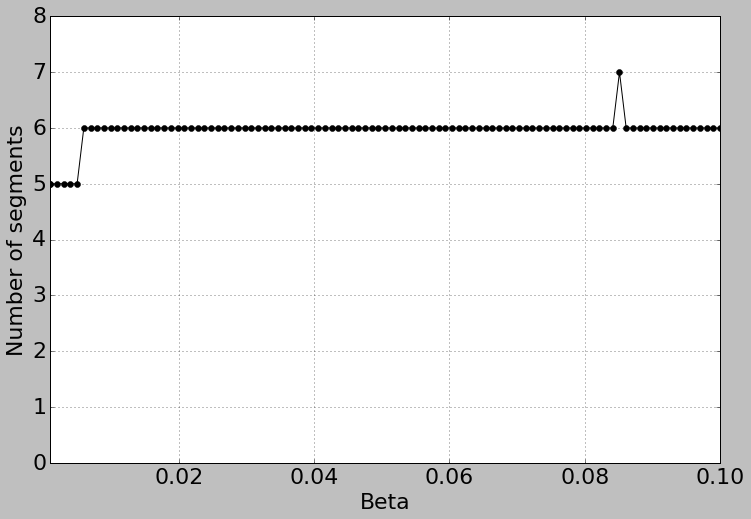

In [25]:
# Create plot for figure 3
from matplotlib import pyplot as plt

figfolder = '/home/paulo/Google Drive/PhD/Trabalhos/FastImplCalibr/JSS/bayeseg/'
plt.style.use('grayscale')
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize = [12, 8])

plot1 = fig.add_subplot(1,1,1)
#plot1.plot([d[1] for d in result if d[1] < 0.001], [d[2] for d in result if d[1] < 0.001], marker = 'o')
plot1.plot(betalist[100:], [len(t)+1 for t in tresult[100:]], marker = 'o')

plt.ylim(0, 8)
plt.xlim(min(betalist[100:]), max(betalist[100:]))
plt.xlabel('Beta')
plt.ylabel('Number of segments')
plt.grid(linestyle = 'dotted')
plt.savefig(figfolder + 'beta_results_2.pdf', dpi = 1000, bbox_inches = 'tight')

## Calibration for a grid of $\beta$ and $\alpha$ with varying delta

Note: the cells below replicate the results of figures 4, p. 18 of the paper

In [30]:
# Signal characteristics
npoints = 1000000
cuts = [10000, 110000, 200000, 500000, 750000, 1000000]
delta = [1.1, 1, 1.5, 1, 1.2]
stdnoise = 1

mciter = 10000
mcburn = 10000

# Alpha grid
alphamin = 0.01
alphamax = 0.99
nstep = 100
adelta = (alphamax - alphamin) / max(1, nstep)
alphalist = [alphamin + d*adelta for d in range(nstep+1)]

# Beta grid
betamin = 0.1
betamax = 0.1
nstep = 0
bdelta = (betamax - betamin) / max(1, nstep)
betalist = [betamin + d*bdelta for d in range(nstep+1)]


# Number of segmentations to run for each combination of parameters
nruns = 1

ss = SeqSeg(replicate = True)
res = []

# To replicate results 
np.random.seed(123456)

# Simulates signal
signal = np.random.normal(0, stdnoise, [npoints, 1])
for i in range(len(cuts)-1):
    signal[cuts[i]:cuts[i+1]] = signal[cuts[i]:cuts[i+1]]*(np.sqrt(delta[i]))


ss.feed_data(signal)        
result = []
tresult = []
cont = 1
ntotal = len(betalist)*len(alphalist)
for alpha in alphalist:
    for beta in betalist:
        ss.initialize(beta, alpha, mciter, mcburn, nchains = 1)
        t, tdur = ss.segments(minlen = 5000, res = 1, verbose = False)
        result.append([alpha, beta, len(t)+1])
        #t.sort()
        tresult.append(t)

        print('({:.2%})'.format(cont/ntotal) + ' Alpha = {:.3}'.format(alpha) + ', Beta = {:.5}'.format(beta) + ", " + str(len(t)+1) + " segments")
        cont = cont + 1         




(0.99%) Alpha = 0.01, Beta = 0.1, 6 segments
(1.98%) Alpha = 0.0198, Beta = 0.1, 6 segments
(2.97%) Alpha = 0.0296, Beta = 0.1, 6 segments
(3.96%) Alpha = 0.0394, Beta = 0.1, 6 segments
(4.95%) Alpha = 0.0492, Beta = 0.1, 6 segments
(5.94%) Alpha = 0.059, Beta = 0.1, 6 segments
(6.93%) Alpha = 0.0688, Beta = 0.1, 6 segments
(7.92%) Alpha = 0.0786, Beta = 0.1, 6 segments
(8.91%) Alpha = 0.0884, Beta = 0.1, 6 segments
(9.90%) Alpha = 0.0982, Beta = 0.1, 6 segments
(10.89%) Alpha = 0.108, Beta = 0.1, 6 segments
(11.88%) Alpha = 0.118, Beta = 0.1, 6 segments
(12.87%) Alpha = 0.128, Beta = 0.1, 6 segments
(13.86%) Alpha = 0.137, Beta = 0.1, 6 segments
(14.85%) Alpha = 0.147, Beta = 0.1, 6 segments
(15.84%) Alpha = 0.157, Beta = 0.1, 6 segments
(16.83%) Alpha = 0.167, Beta = 0.1, 6 segments
(17.82%) Alpha = 0.177, Beta = 0.1, 6 segments
(18.81%) Alpha = 0.186, Beta = 0.1, 6 segments
(19.80%) Alpha = 0.196, Beta = 0.1, 6 segments
(20.79%) Alpha = 0.206, Beta = 0.1, 6 segments
(21.78%) Alpha =

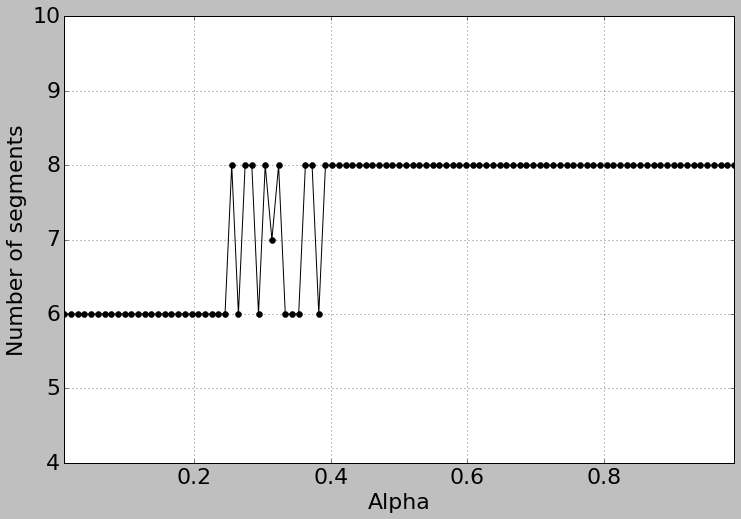

In [34]:
# Create plot for figure 4
from matplotlib import pyplot as plt

figfolder = '/home/paulo/Google Drive/PhD/Trabalhos/FastImplCalibr/JSS/bayeseg/'
plt.style.use('grayscale')
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize = [12, 8])

plot1 = fig.add_subplot(1,1,1)
#plot1.plot([d[1] for d in result if d[1] < 0.001], [d[2] for d in result if d[1] < 0.001], marker = 'o')
plot1.plot(alphalist, [len(t)+1 for t in tresult], marker = 'o')

plt.ylim(4, 10)
plt.xlim(min(alphalist), max(alphalist))
plt.xlabel('Alpha')
plt.ylabel('Number of segments')
plt.grid(linestyle = 'dotted')
plt.savefig(figfolder + 'alpha_results.pdf', dpi = 1000, bbox_inches = 'tight')


## Testing the algorithm on real samples

Note: the cells below replicate the results from Table 7, p. 21 of the paper

In [35]:
from bayeseg.OceanPod import OceanPod 


wavfolder = '/home/paulo/github/bayeseg/Data/'
savefolder = '/home/paulo/github/bayeseg/Output/'
filelist = ['2015.01.30_02.02.56.wav', '2015.02.02_07.50.49.wav', '2015.02.08_11.26.39.wav']

# Creates object to read wave files and segments
op = OceanPod(wavfolder)

In [36]:
# MCMC parameters

mciter = 20000
mcburn = 20000
nchains = 1


In [41]:
# Beta grid

betamin = 5e-6
betamax = 5e-5
nstep = 6
bdelta = (betamax - betamin) / max(nstep, 1)
betalist = [betamin + d*bdelta for d in range(nstep+1)]


In [42]:
# Alpha grid

alphamin = 0.1
alphamax = 0.1

nstep = 0
adelta = (alphamax - alphamin) / max(nstep, 1)
alphalist = [alphamin + d*adelta for d in range(nstep+1)]

In [51]:
# Main loop
ss = SeqSeg(replicate = True)

nruns = 1

tresults = []
results = []
cont = 1
total = len(filelist) * len(alphalist) * len(betalist)
for file in filelist:
    fs, wave = op.readFile(file)
    ss.feed_data(wave)
    for alpha in alphalist:
        for beta in betalist:
            ss.initialize(beta, alpha, mciter, mcburn, nchains)
            resiter = []
            for i in range(nruns):
                t, tdur = ss.segments(minlen = 11025, res = 11025, verbose = False)
                nseg = len(t) + 1
                resiter.append([nseg, tdur])
                tresults.append([file, t])
            meannseg = np.mean([r[0] for r in resiter])
            stdseg = np.std([r[0] for r in resiter])
            tmean = np.mean([r[1] for r in resiter])
            print("({:.4%})".format(cont/total) + file + ", a = {:.2}".format(alpha) + ", b = {:.6}".format(beta) + ", Nseg = " + str(meannseg) + ", Nsegstd = " + str(stdseg) + ", t = {:.2}".format(tmean))
            cont = cont + 1
            results.append([file, alpha, beta, meannseg, stdseg, tmean])
            
            
    

(4.7619%)2015.01.30_02.02.56.wav, a = 0.1, b = 5e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.084
(9.5238%)2015.01.30_02.02.56.wav, a = 0.1, b = 1.25e-05, Nseg = 2.0, Nsegstd = 0.0, t = 0.14
(14.2857%)2015.01.30_02.02.56.wav, a = 0.1, b = 2e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.18
(19.0476%)2015.01.30_02.02.56.wav, a = 0.1, b = 2.75e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(23.8095%)2015.01.30_02.02.56.wav, a = 0.1, b = 3.5e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(28.5714%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.25e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.16
(33.3333%)2015.01.30_02.02.56.wav, a = 0.1, b = 5e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.18
(38.0952%)2015.02.02_07.50.49.wav, a = 0.1, b = 5e-06, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(42.8571%)2015.02.02_07.50.49.wav, a = 0.1, b = 1.25e-05, Nseg = 4.0, Nsegstd = 0.0, t = 0.2
(47.6190%)2015.02.02_07.50.49.wav, a = 0.1, b = 2e-05, Nseg = 7.0, Nsegstd = 0.0, t = 0.3
(52.3810%)2015.02.02_07.50.49.wav, a = 0.1, b = 2.75e-05, Nseg = 7.0, Nsegstd =

In [52]:
df = pd.DataFrame({'Ample' : [r[0] for r in results], 'Beta' : [r[2] for r in results], 'Segments' : [r[3] for r in results], 'Time' : [r[5] for r in results]})
print(df.to_latex(index = False))

\begin{tabular}{lrrr}
\toprule
                   Ample &      Beta &  Segments &      Time \\
\midrule
 2015.01.30\_02.02.56.wav &  0.000005 &       1.0 &  0.083694 \\
 2015.01.30\_02.02.56.wav &  0.000013 &       2.0 &  0.136560 \\
 2015.01.30\_02.02.56.wav &  0.000020 &       3.0 &  0.178109 \\
 2015.01.30\_02.02.56.wav &  0.000028 &       3.0 &  0.172211 \\
 2015.01.30\_02.02.56.wav &  0.000035 &       3.0 &  0.170295 \\
 2015.01.30\_02.02.56.wav &  0.000043 &       3.0 &  0.159664 \\
 2015.01.30\_02.02.56.wav &  0.000050 &       3.0 &  0.176790 \\
 2015.02.02\_07.50.49.wav &  0.000005 &       3.0 &  0.166642 \\
 2015.02.02\_07.50.49.wav &  0.000013 &       4.0 &  0.204818 \\
 2015.02.02\_07.50.49.wav &  0.000020 &       7.0 &  0.303860 \\
 2015.02.02\_07.50.49.wav &  0.000028 &       7.0 &  0.301785 \\
 2015.02.02\_07.50.49.wav &  0.000035 &       7.0 &  0.297572 \\
 2015.02.02\_07.50.49.wav &  0.000043 &       9.0 &  0.356854 \\
 2015.02.02\_07.50.49.wav &  0.000050 &      11.0 &

(0.3300%)2015.01.30_02.02.56.wav, a = 0.1, b = 5e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.082
(0.6601%)2015.01.30_02.02.56.wav, a = 0.1, b = 5.45e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.093
(0.9901%)2015.01.30_02.02.56.wav, a = 0.1, b = 5.9e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.095
(1.3201%)2015.01.30_02.02.56.wav, a = 0.1, b = 6.35e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.091
(1.6502%)2015.01.30_02.02.56.wav, a = 0.1, b = 6.8e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.085
(1.9802%)2015.01.30_02.02.56.wav, a = 0.1, b = 7.25e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.091
(2.3102%)2015.01.30_02.02.56.wav, a = 0.1, b = 7.7e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.099
(2.6403%)2015.01.30_02.02.56.wav, a = 0.1, b = 8.15e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.099
(2.9703%)2015.01.30_02.02.56.wav, a = 0.1, b = 8.6e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.099
(3.3003%)2015.01.30_02.02.56.wav, a = 0.1, b = 9.05e-06, Nseg = 1.0, Nsegstd = 0.0, t = 0.09
(3.6304%)2015.01.30_02.02.56.wav, a = 0.1, b = 9.5e-06, Nseg = 1.0, 

(29.3729%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.46e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(29.7030%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.505e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.18
(30.0330%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.55e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.16
(30.3630%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.595e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(30.6931%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.64e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(31.0231%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.685e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.16
(31.3531%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.73e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(31.6832%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.775e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(32.0132%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.82e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.18
(32.3432%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.865e-05, Nseg = 3.0, Nsegstd = 0.0, t = 0.17
(32.6733%)2015.01.30_02.02.56.wav, a = 0.1, b = 4.91e-0

(58.4158%)2015.02.02_07.50.49.wav, a = 0.1, b = 3.875e-05, Nseg = 7.0, Nsegstd = 0.0, t = 0.3
(58.7459%)2015.02.02_07.50.49.wav, a = 0.1, b = 3.92e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.36
(59.0759%)2015.02.02_07.50.49.wav, a = 0.1, b = 3.965e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.36
(59.4059%)2015.02.02_07.50.49.wav, a = 0.1, b = 4.01e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.35
(59.7360%)2015.02.02_07.50.49.wav, a = 0.1, b = 4.055e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.35
(60.0660%)2015.02.02_07.50.49.wav, a = 0.1, b = 4.1e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.35
(60.3960%)2015.02.02_07.50.49.wav, a = 0.1, b = 4.145e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.35
(60.7261%)2015.02.02_07.50.49.wav, a = 0.1, b = 4.19e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.39
(61.0561%)2015.02.02_07.50.49.wav, a = 0.1, b = 4.235e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.35
(61.3861%)2015.02.02_07.50.49.wav, a = 0.1, b = 4.28e-05, Nseg = 9.0, Nsegstd = 0.0, t = 0.36
(61.7162%)2015.02.02_07.50.49.wav, a = 0.1, b = 4.325e-05

(87.1287%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.245e-05, Nseg = 28.0, Nsegstd = 0.0, t = 0.89
(87.4587%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.29e-05, Nseg = 28.0, Nsegstd = 0.0, t = 0.89
(87.7888%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.335e-05, Nseg = 28.0, Nsegstd = 0.0, t = 0.89
(88.1188%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.38e-05, Nseg = 29.0, Nsegstd = 0.0, t = 0.94
(88.4488%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.425e-05, Nseg = 29.0, Nsegstd = 0.0, t = 0.93
(88.7789%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.47e-05, Nseg = 29.0, Nsegstd = 0.0, t = 0.94
(89.1089%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.515e-05, Nseg = 29.0, Nsegstd = 0.0, t = 0.92
(89.4389%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.56e-05, Nseg = 29.0, Nsegstd = 0.0, t = 0.93
(89.7690%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.605e-05, Nseg = 29.0, Nsegstd = 0.0, t = 0.92
(90.0990%)2015.02.08_11.26.39.wav, a = 0.1, b = 3.65e-05, Nseg = 29.0, Nsegstd = 0.0, t = 0.92
(90.4290%)2015.02.08_11.26.39.wav, a = 0.1, b

ValueError: x and y must have same first dimension

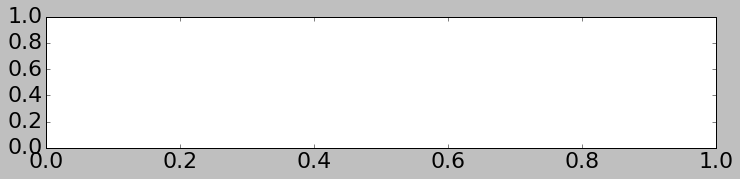

In [56]:
# Figure 11

betamin = 5e-6
betamax = 5e-5
nstep = 100
bdelta = (betamax - betamin) / max(nstep, 1)
betalist = [betamin + d*bdelta for d in range(nstep+1)]

ss = SeqSeg(replicate = True)

nruns = 1

tresults = []
results = []
cont = 1
total = len(filelist) * len(alphalist) * len(betalist)
for file in filelist:
    fs, wave = op.readFile(file)
    ss.feed_data(wave)
    for alpha in alphalist:
        for beta in betalist:
            ss.initialize(beta, alpha, mciter, mcburn, nchains)
            resiter = []
            for i in range(nruns):
                t, tdur = ss.segments(minlen = 11025, res = 11025, verbose = False)
                nseg = len(t) + 1
                resiter.append([nseg, tdur])
                tresults.append([file, t])
            meannseg = np.mean([r[0] for r in resiter])
            stdseg = np.std([r[0] for r in resiter])
            tmean = np.mean([r[1] for r in resiter])
            print("({:.4%})".format(cont/total) + file + ", a = {:.2}".format(alpha) + ", b = {:.6}".format(beta) + ", Nseg = " + str(meannseg) + ", Nsegstd = " + str(stdseg) + ", t = {:.2}".format(tmean))
            cont = cont + 1
            results.append([file, alpha, beta, meannseg, stdseg, tmean])

df = pd.DataFrame({'s' : [r[0] for r in results], 'beta' : [r[2] for r in results], 'seg' : [r[3] for r in results]})

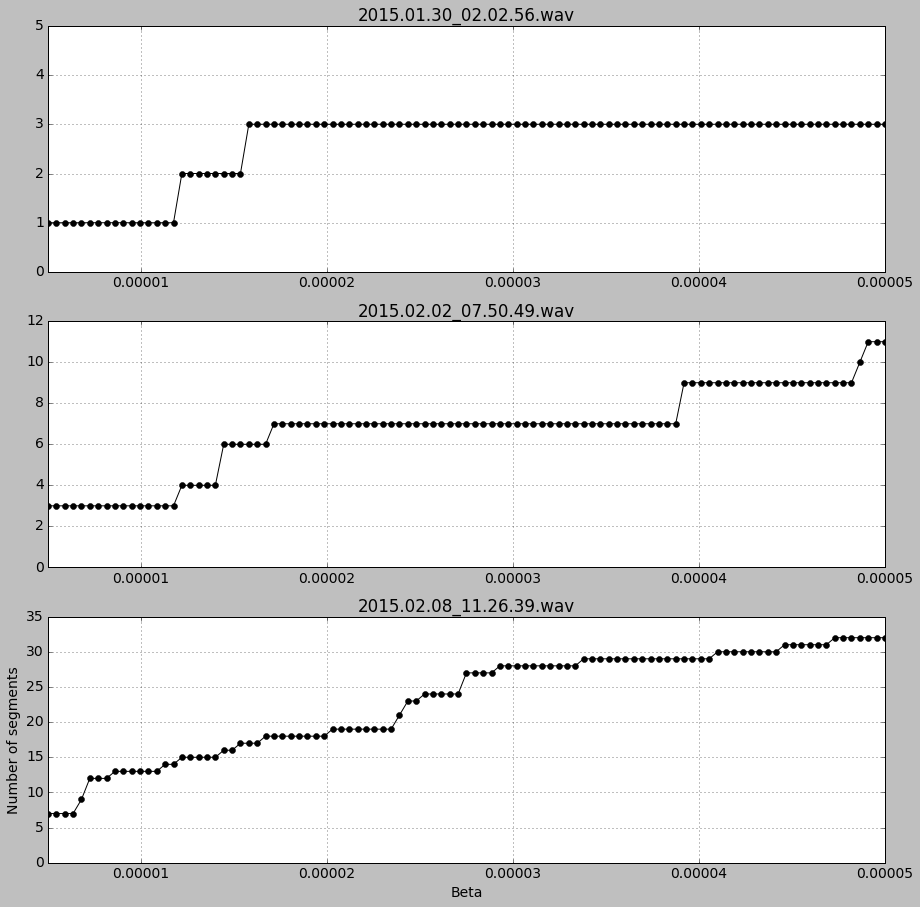

In [77]:
# Create plot for figure 4
from matplotlib import pyplot as plt

figfolder = '/home/paulo/Google Drive/PhD/Trabalhos/FastImplCalibr/JSS/bayeseg/'
plt.style.use('grayscale')
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize = [15, 15])

plot1 = fig.add_subplot(3,1,1)
plot1.plot(betalist, df.loc[df.s == '2015.01.30_02.02.56.wav', 'seg'], marker = 'o')
plot1.set_title('2015.01.30_02.02.56.wav')
plt.grid(linestyle = 'dotted')
plt.ylim(0, 5)
plt.xlim(min(betalist), max(betalist))

plot2 = fig.add_subplot(3,1,2)
plot2.plot(betalist, df.loc[df.s == '2015.02.02_07.50.49.wav', 'seg'], marker = 'o')
plot2.set_title('2015.02.02_07.50.49.wav')
plt.grid(linestyle = 'dotted')
plt.ylim(0, 12)
plt.xlim(min(betalist), max(betalist))

plot3 = fig.add_subplot(3,1,3)
plot3.plot(betalist, df.loc[df.s == '2015.02.08_11.26.39.wav', 'seg'], marker = 'o')
plot3.set_title('2015.02.08_11.26.39.wav')
plt.ylim(0, 35)
plt.xlim(min(betalist), max(betalist))

plt.xlabel('Beta')
plt.ylabel('Number of segments')
plt.grid(linestyle = 'dotted')
plt.savefig(figfolder + 'alpha_beta_all_sig.pdf', dpi = 1000, bbox_inches = 'tight')

## Final segmentation

Note: the cell below output files "20150202.csv" and "20150208.csv", with the segmentation points that are used on figures 9 and 10, p. 23 of the paper

In [15]:
from bayeseg.OceanPod import OceanPod 


wavfolder = '/home/paulo/github/bayeseg/Data/'
savefolder = '/home/paulo/github/bayeseg/Output/'
filelist = ['2015.01.30_02.02.56.wav', '2015.02.02_07.50.49.wav', '2015.02.08_11.26.39.wav']

# Creates object to read wave files and segments
op = OceanPod(wavfolder)
ss = SeqSeg(replicate = True)

# Parameters
alpha = 0.1
mciter = 20000
mcburn = 10000
nchains = 1


# 2015-02-02
beta = 9.5e-06

file = filelist[1]
fs, wave = op.readFile(file)
ss.feed_data(wave)
ss.initialize(beta, alpha, mciter, mcburn, nchains)
t, tdur = ss.segments(minlen = 11025, res = 11025, verbose = False)
nseg = len(t) + 1

# Creating file
with open(wavfolder + '20150202.csv', 'w') as arq:
    arq.write(",".join([str(i) for i in t]))
    

# 2015-02-08    
beta = 3.11e-05

file = filelist[2]
fs, wave = op.readFile(file)
ss.feed_data(wave)
ss.initialize(beta, alpha, mciter, mcburn, nchains)
t, tdur = ss.segments(minlen = 11025, res = 11025, verbose = False)
nseg = len(t) + 1

# Creating file
with open(wavfolder + '20150208.csv', 'w') as arq:
    arq.write(",".join([str(i) for i in t]))